## <font color='Blue'>Introduction</font>
###  In this exercise, we run simulation in a 2D single layer two-phase model.
* The realistic formation heterogeneity is used for permeability map. 

## <font color='blue'>The objectives:</font>
1. Introduce custom <font color='red'>'Model'</font> class based on 
 * Class [DartsModel](darts/models/darts_model.py) with base model capabilities
 * Class [StructReservoir](darts/models/reservoirs/struct_reservoir.py) with structured reservoir
 * Class [SuperPhysics](physics/physics_comp_sup.py) for basic physics where super engine is used
 * Class [PropertyContainer](physics/property_container.py) for allocating property evaluator needed in the simulation
 * Class [Properties](physics/properties_dead_oil.py) for dead oil properties in this practice, such as density, viscosity and relative permeability. It should be changed based on the investigated problem.
2. Use run_python procedure to control run from the python script
3. Introduce wells and time-dependent well controls
4. Redefine physical properties and run simulation with custom-defined property.

## <font color='Blue'>Let's start!</font>


<img style="float: left;" src="slides/Slide33.JPG" width="60%">

In [31]:
from darts.models.reservoirs.struct_reservoir import StructReservoir
from darts.models.darts_model import DartsModel
from physics.physics_comp_sup import SuperPhysics
from physics.property_container import *
from physics.properties_dead_oil import *
from darts.engines import *
import numpy as np
redirect_darts_output('log.txt')

<img style="float: left;" src="slides/Slide34.JPG" width="60%">

#### Brief Introduction of model inheritance
* Here create the <font color='red'>'Model' </font>  class, which inherits from <font color='red'>DartsModel</font> (the base class).
* It keeps all the functionalities of <font color='red'>DartsModel</font> and can also be extended to add more functionalities.
* If a function is redefined in subclass, the function in base class with identical name will be overridden.

In [32]:
class Model(DartsModel):
    def __init__(self):
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = 60
        self.ny = 60
        self.nz = 1
        
        self.dx = 8
        self.dy = 8
        self.dz = 4

        self.permx = np.ones(self.nx*self.ny)*1000
        self.actnum = np.ones(self.nx*self.ny)
        
#         self.permx = load_single_keyword('Egg/data.in','PERMX')
#         self.actnum = load_single_keyword('Egg/data.in','ACTNUM')            
        
        self.permy = self.permx
        self.permz = 0.1 * self.permx
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth,actnum=self.actnum)
        
        self.well_init()
               
        """Physical properties"""
        self.pvt = 'Egg/physics.in'
        self.zero = 1e-13
        self.property_container = model_properties(phases_name=['water', 'oil'], components_name=['w', 'o'], 
                                                   pvt=self.pvt, min_z=self.zero/10)

        # Define property evaluators based on custom properties
        self.flash_ev = []
        self.property_container.density_ev = dict([('water', DensityWat(self.pvt)),
                                                   ('oil', DensityOil(self.pvt))])
        self.property_container.viscosity_ev = dict([('water', ViscoWat(self.pvt)),
                                                     ('oil', ViscoOil(self.pvt))])
        self.property_container.rel_perm_ev = dict([('water', WatRelPerm(self.pvt)),
                                                    ('oil', OilRelPerm(self.pvt))])
        self.property_container.capillary_pressure_ev = CapillarypressurePcow(self.pvt)

        self.property_container.rock_compress_ev = RockCompactionEvaluator(self.pvt)

        # create physics
        self.thermal = 0
        self.physics = SuperPhysics(self.property_container, self.timer, n_points=400, min_p=0, max_p=1000,
                                     min_z=self.zero, max_z=1 - self.zero, thermal=self.thermal)

        self.params.first_ts = 0.01
        self.params.mult_ts = 2
        self.params.max_ts = 10
        self.params.tolerance_newton = 1e-2
        self.params.tolerance_linear = 1e-4

        self.inj = [0.999]

        self.runtime = 300

        self.timer.node["initialization"].stop()
        
    def well_init(self):
        
        # add two wells
        well_diam = 0.2
        well_rad = well_diam/2
           
        self.reservoir.add_well("INJ1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], 5, 57, 1, well_radius=well_rad, multi_segment=False)
        self.reservoir.inj_wells = [self.reservoir.wells[-1]]        

        self.reservoir.add_well("PRD1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], 43, 18, 1, well_radius=well_rad, multi_segment=False)
        self.reservoir.prod_wells = [self.reservoir.wells[-1]]

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[2e-2])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if "INJ" in w.name:
                w.control = self.physics.new_rate_inj(200, self.inj, 0)
                w.constraint = self.physics.new_bhp_inj(450, self.inj)
            else:
                w.control = self.physics.new_bhp_prod(390)

<img style="float: left;" src="slides/Slide45.JPG" width="60%">

<img style="float: left;" src="slides/Slide46.JPG" width="60%">

<img style="float: left;" src="slides/Slide35.JPG" width="60%">

In [57]:
# evaluate all properties which are needed in the simulation
class model_properties(property_container):
    def __init__(self, phases_name, components_name, pvt, min_z=1e-11):
        # Call base class constructor
        self.nph = len(phases_name)
        Mw = np.ones(self.nph)
        super().__init__(phases_name, components_name, Mw, min_z)
        self.x = np.zeros((self.nph, self.nc))
        self.pvt = pvt
        self.surf_dens = get_table_keyword(self.pvt, 'DENSITY')[0]
        self.surf_oil_dens = self.surf_dens[0]
        self.surf_wat_dens = self.surf_dens[1]

    def evaluate(self, state):
        """
        Class methods which evaluates the state operators for the element based physics
        :param state: state variables [pres, comp_0, ..., comp_N-1]
        :param values: values of the operators (used for storing the operator values)
        :return: updated value for operators, stored in values
        """
        # Composition vector and pressure from state:
        vec_state_as_np = np.asarray(state)
        pressure = vec_state_as_np[0]

        zc = np.append(vec_state_as_np[1:], 1 - np.sum(vec_state_as_np[1:]))

        self.clean_arrays()
        # two-phase flash - assume water phase is always present and water component last
        for i in range(self.nph):
            self.x[i, i] = 1

        ph = [0, 1]

        for j in ph:
            M = 0
            # molar weight of mixture
            for i in range(self.nc):
                M += self.Mw[i] * self.x[j][i]
            self.dens[j] = self.density_ev[self.phases_name[j]].evaluate(state)  # output in [kg/m3]
            self.dens_m[j] = self.dens[j] / M
            self.mu[j] = self.viscosity_ev[self.phases_name[j]].evaluate(state)  # output in [cp]

        self.nu = zc
        self.compute_saturation(ph)
        
        # when evaluate rel-perm based on the table, we only need water saturation to interpolate both phases saturation
        for j in ph:
            self.kr[j] = self.rel_perm_ev[self.phases_name[j]].evaluate(self.sat[0])
            self.pc[j] = 0

        return self.sat, self.x, self.dens, self.dens_m, self.mu, self.kr, self.pc, ph

    def evaluate_at_cond(self, pressure, zc):

        self.sat[:] = 0

        state = value_vector([1, 0])

        ph = [0, 1]
        for j in ph:
            self.dens_m[j] = self.density_ev[self.phases_name[j]].evaluate(state)

        self.dens_m = [self.surf_wat_dens, self.surf_oil_dens]  # to match DO based on PVT

        self.nu = zc
        self.compute_saturation(ph)

        return self.sat, self.dens_m

<img style="float: left;" src="slides/Slide36.JPG" width="60%">

In [35]:
m = Model()
m.init()
m.run_python()
m.print_timers()


darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8
Building connection list...
# 1 	T = 0.01	DT = 0.01	NI = 2	LI=5
# 2 	T = 0.03	DT = 0.02	NI = 1	LI=3
# 3 	T = 0.07	DT = 0.04	NI = 2	LI=8
# 4 	T = 0.15	DT = 0.08	NI = 3	LI=12
# 5 	T = 0.31	DT = 0.16	NI = 2	LI=10
# 6 	T = 0.63	DT = 0.32	NI = 3	LI=14
# 7 	T = 1.27	DT = 0.64	NI = 3	LI=18
# 8 	T = 2.55	DT = 1.28	NI = 4	LI=25
# 9 	T = 5.11	DT = 2.56	NI = 5	LI=32
# 10 	T = 10.23	DT = 5.12	NI = 6	LI=42
# 11 	T = 20.23	DT = 10	NI = 9	LI=67
# 12 	T = 30.23	DT = 10	NI = 8	LI=59
# 13 	T = 40.23	DT = 10	NI = 7	LI=49
# 14 	T = 50.23	DT = 10	NI = 6	LI=43
# 15 	T = 60.23	DT = 10	NI = 6	LI=42
# 16 	T = 70.23	DT = 10	NI = 6	LI=41
# 17 	T = 80.23	DT = 10	NI = 5	LI=34
# 18 	T = 90.23	DT = 10	NI = 5	LI=35
# 19 	T = 100.23	DT = 10	NI = 5	LI=35
# 20 	T = 110.23	DT = 10	NI = 5	LI=35
# 21 	T = 120.23	DT = 10	NI = 4	LI=27
# 22 	T = 130.23	DT = 10	NI = 4	LI=28
# 23 	T = 140.23	DT = 10	NI = 4	LI=27
# 24 	T = 150.23	DT = 10	NI = 4	LI=27
# 25 

<img style="float: left;" src="slides/Slide37.JPG" width="60%">

In [34]:
%matplotlib inline
import pandas as pd
time_data = pd.DataFrame.from_dict(m.physics.engine.time_data)
# wirte timedata to output file
time_data.to_pickle("darts_time_data.pkl")
# write timedata to excel file
writer = pd.ExcelWriter('time_data.xlsx')
time_data.to_excel(writer, 'Sheet1')
writer.save()

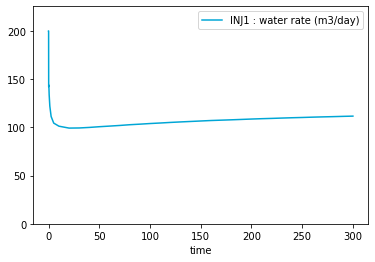

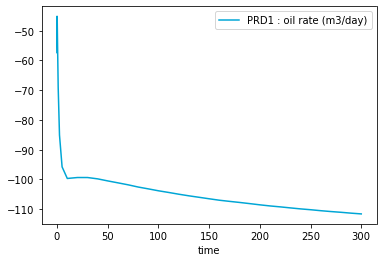

In [10]:
td=pd.read_pickle("darts_time_data.pkl")
from darts.tools.plot_darts import *
plot_water_rate_darts("INJ1",time_data)
plot_oil_rate_darts("PRD1",time_data)
plt.show()

<img style="float: left;" src="slides/Slide38.JPG" width="60%">

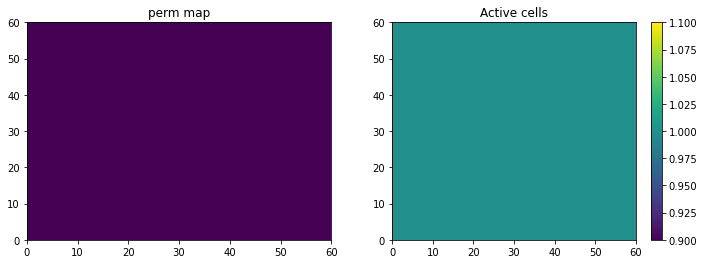

In [38]:
import matplotlib.pyplot as plt
plt.figure(num=1, figsize=(12, 4))
plt.subplot(121)
perm = np.array(m.permx)
plt.pcolor(perm.reshape(m.ny, m.nx))
plt.title('perm map')
act=np.array(m.actnum)
plt.subplot(122)
plt.pcolor(act.reshape(m.ny, m.nx))
plt.title('Active cells')
plt.colorbar()

### Next we process the active grid, prepare plotting and plot pressure

Text(0.5, 1.0, 'pressure')

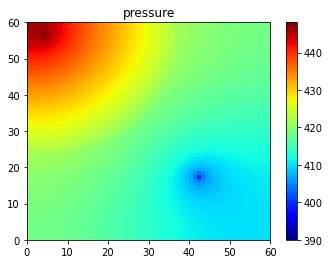

In [39]:
import matplotlib.pyplot as plt
from darts.models.physics.do_operator_python import *

# process active grid
X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny
nb = np.count_nonzero(m.actnum)

p = -np.ones(m.nx*m.ny)
z = -np.ones(m.nx*m.ny)
s = -np.ones(m.nx*m.ny)

p[act>0] = X[0:2*nb:2]
z[act>0] = X[1:2*nb:2]


plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx),cmap='jet')
plt.clim([390,max(p)])
plt.colorbar()
plt.title('pressure')


<img style="float: left;" src="slides/Slide39.JPG" width="60%">

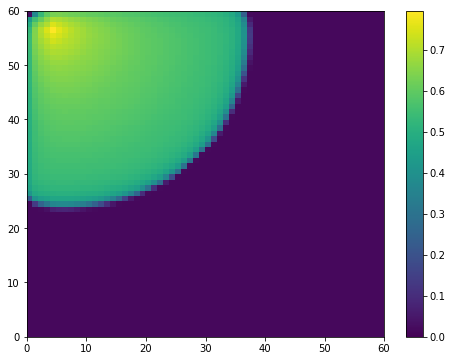

In [40]:
for i in range(m.ny*m.nx):
    values = value_vector([0]*m.physics.n_ops)
    state = value_vector([p[i], z[i]])
    m.physics.property_itor.evaluate(state, values)
    s[i] = values[0]

plt.figure(figsize=(8,6))
plt.pcolor(s.reshape(m.ny, m.nx))
plt.colorbar()
# plt.title('Water saturation')
plt.clim([0,max(s)])
plt.show()

<img style="float: left;" src="slides/Slide40.JPG" width="60%">

In [52]:
class Model(DartsModel):
    def __init__(self):
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = 60
        self.ny = 60
        self.nz = 1
        
        self.dx = 8
        self.dy = 8
        self.dz = 4

        #self.permx = np.ones(self.nx*self.ny)*1000
        #self.actnum = np.ones(self.nx*self.ny)
        
        self.permx = load_single_keyword('Egg/data.in','PERMX')
        self.actnum = load_single_keyword('Egg/data.in','ACTNUM')            
        
        self.permy = self.permx
        self.permz = 0.1 * self.permx
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth,actnum=self.actnum)
        
        self.well_init()
               
        """Physical properties"""
        self.pvt = 'Egg/physics.in'
        self.zero = 1e-13
        self.property_container = model_properties(phases_name=['water', 'oil'], components_name=['w', 'o'], 
                                                   pvt=self.pvt, min_z=self.zero/10)

        # Define property evaluators based on custom properties
        self.flash_ev = []
        self.property_container.density_ev = dict([('water', DensityWat(self.pvt)),
                                                   ('oil', DensityOil(self.pvt))])
        self.property_container.viscosity_ev = dict([('water', ViscoWat(self.pvt)),
                                                     ('oil', ViscoOil(self.pvt))])
        self.property_container.rel_perm_ev = dict([('water', WatRelPerm(self.pvt)),
                                                    ('oil', OilRelPerm(self.pvt))])
        self.property_container.capillary_pressure_ev = CapillarypressurePcow(self.pvt)

        self.property_container.rock_compress_ev = RockCompactionEvaluator(self.pvt)

        # create physics
        self.thermal = 0
        self.physics = SuperPhysics(self.property_container, self.timer, n_points=400, min_p=0, max_p=1000,
                                     min_z=self.zero, max_z=1 - self.zero, thermal=self.thermal)

        self.params.first_ts = 0.01
        self.params.mult_ts = 2
        self.params.max_ts = 10
        self.params.tolerance_newton = 1e-2
        self.params.tolerance_linear = 1e-4

        self.inj = [0.999]

        self.runtime = 300

        self.timer.node["initialization"].stop()
        
    def well_init(self):
        
        # add two wells
        well_diam = 0.2
        well_rad = well_diam/2

        
        self.reservoir.add_well("INJ1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], 5, 57, 1, well_radius=well_rad, multi_segment=False)
        self.reservoir.inj_wells = [self.reservoir.wells[-1]] 



        self.reservoir.add_well("PRD1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], 43, 18, 1, well_radius=well_rad, multi_segment=False)
        self.reservoir.prod_wells = [self.reservoir.wells[-1]]

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[2e-2])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if "INJ" in w.name:
                w.control = self.physics.new_rate_inj(200, self.inj, 0)
                w.constraint = self.physics.new_bhp_inj(450, self.inj)
            else:
                w.control = self.physics.new_bhp_prod(390)

Text(0.5, 1.0, 'permx')

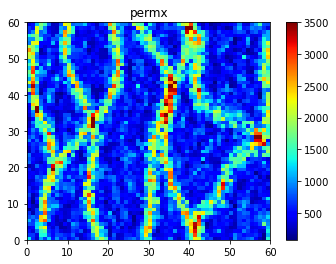

In [53]:
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(permx.reshape(m.ny, m.nx),cmap='jet')
plt.colorbar()
plt.title('permx')

In [59]:
m = Model()
m.init()
m.run_python()
m.print_timers()


darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8
Reading PERMX from c:\Users\bgy3\OneDrive - PETROBRAS\Documents\PhD\01.darts-basics\Egg\data.in... 3600 values have been read.
Reading ACTNUM from c:\Users\bgy3\OneDrive - PETROBRAS\Documents\PhD\01.darts-basics\Egg\data.in... 3600 values have been read.
Building connection list...
Applying ACTNUM...
Inactive blocks due to ACTNUM:  1109
Inactive connections due to transmissibility:  0
Inactive connections total:  2213
Inactive blocks due to inactive connections:  0
# 1 	T = 0.01	DT = 0.01	NI = 2	LI=6
# 2 	T = 0.03	DT = 0.02	NI = 1	LI=4
# 3 	T = 0.07	DT = 0.04	NI = 1	LI=5
# 4 	T = 0.15	DT = 0.08	NI = 2	LI=10
# 5 	T = 0.31	DT = 0.16	NI = 2	LI=10
# 6 	T = 0.63	DT = 0.32	NI = 2	LI=12
# 7 	T = 1.27	DT = 0.64	NI = 3	LI=18
# 8 	T = 2.55	DT = 1.28	NI = 4	LI=28
# 9 	T = 5.11	DT = 2.56	NI = 5	LI=35
# 10 	T = 10.23	DT = 5.12	NI = 7	LI=51
# 11 	T = 20.23	DT = 10	NI = 10	LI=78
# 12 	T = 30.23	DT = 10	NI = 9	LI=68
# 13 	T = 40

In [63]:
 %matplotlib inline
import pandas as pd
time_data = pd.DataFrame.from_dict(m.physics.engine.time_data)
# wirte timedata to output file
time_data.to_pickle("darts_time_data.pkl")
# write timedata to excel file
writer = pd.ExcelWriter('time_data.xlsx')
time_data.to_excel(writer, 'Sheet1')
writer.save()

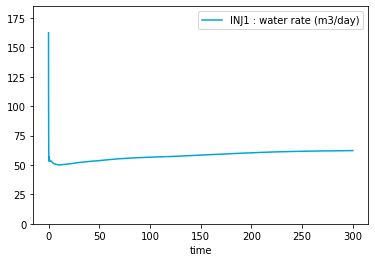

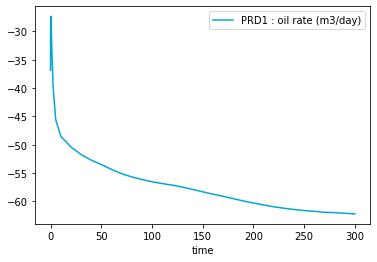

In [64]:
td=pd.read_pickle("darts_time_data.pkl")
from darts.tools.plot_darts import *
plot_water_rate_darts("INJ1",time_data)
plot_oil_rate_darts("PRD1",time_data)
plt.show()

Text(0.5, 1.0, 'Active perm map')

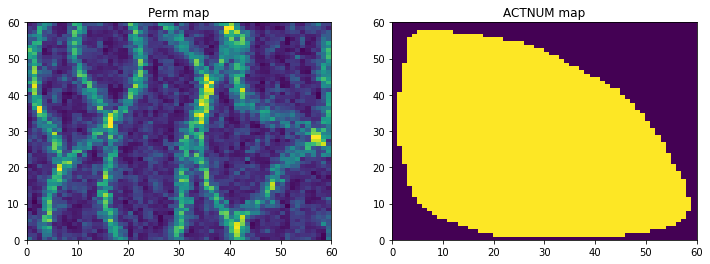

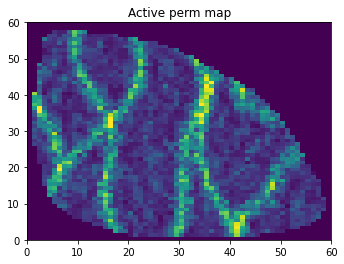

In [84]:
import matplotlib.pyplot as plt

plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
perm = np.array(m.permx[0:m.nx*m.ny])
plt.pcolor(perm.reshape(m.ny, m.nx))
plt.title('Perm map')

plt.figure(num=1, figsize=(12,4))
plt.subplot(122)
act = np.array(m.actnum[0:m.nx*m.ny])
plt.pcolor(act.reshape(m.ny, m.nx))
plt.title('ACTNUM map')

plt.figure(num=2, figsize=(12,4))
plt.subplot(122)
act_perm = np.array(act*perm).reshape(m.ny, m.nx)
plt.pcolor(act_perm)
plt.title('Active perm map')


<img style="float: left;" src="slides/Slide41.JPG" width="60%">

<img style="float: left;" src="slides/Slide42.JPG" width="60%">

Text(0.5, 1.0, 'pressure')

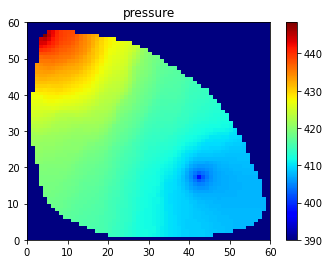

In [74]:
# process active grid
X = np.array(m.physics.engine.X, copy=False)
nb =act[act>0].size

p[act>0] = X[0:2*nb:2]
z[act>0] = X[1:2*nb:2]


plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx),cmap='jet')
plt.clim([390,max(p)])
plt.colorbar()
plt.title('pressure')

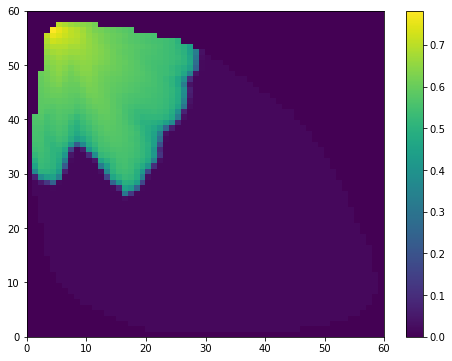

In [75]:
for i in range(m.ny*m.nx):
    values = value_vector([0]*m.physics.n_ops)
    state = value_vector([p[i], z[i]])
    m.physics.property_itor.evaluate(state, values)
    s[i] = values[0]

plt.figure(figsize=(8,6))
plt.pcolor(s.reshape(m.ny, m.nx))
plt.colorbar()
# plt.title('Water saturation')
plt.clim([0,max(s)])
plt.show() 

<img style="float: left;" src="slides/Slide43.JPG" width="60%">

<img style="float: left;" src="slides/Slide44.JPG" width="60%">